In [24]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.visualization import astropy_mpl_style, quantity_support
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS, Longitude
from astropy.time import Time
from helpers.ArrayCoordinate import MidPositions

# plt.style.use(astropy_mpl_style)

In [2]:
"""Turn into a single Command

plotObservable(array,targets,start_time,obs_period,print)
"""

'Turn into a single Command\n\nplotObservable(array,targets,start_time,obs_period,print)\n'

## Load array positions

In [48]:
desired_array = 'Mid' #(or 'Low')
if desired_array == 'Mid':
    print("Array:"+desired_array+"\nUsing only SKA dishes ")
    ska_dishes = MidPositions('AncillData/mid_array_coords.dat','SKA',1000.0)
    ska_average_position = ska_dishes.array_ave_position()
    geographic_location = EarthLocation.from_geocentric(ska_average_position['ave_x'],
                                                        ska_average_position['ave_y'],
                                                        ska_average_position['ave_z'],unit=u.m)
    utcoffset = +2*u.hour  # FIX!
    time_now = Time(datetime.utcnow(), scale='utc') - utcoffset
    time_zone = '[SAST]'
    
elif desired_array == 'Low':
    print('FILL THIS IN ADAM')
    """
    array_x = [1.0]
    array_y = [2.0]
    array_z = [3.0]
    
    geographic_location = EarthLocation.of_site('MeerKAT')
    utcoffset = +8*u.hour  # FIX!
    time_now = Time(datetime.utcnow(), scale='utc') - utcoffset
    """
else:
    print("That is not an SKA Telescope ")
    

Array:Mid
Using only SKA dishes 


## Define Time range

In [37]:
obs_period_length = 24.0*u.hour

obs_period_start = Time('2023-7-5 12:00:00') # UTC
obs_period_start_local = obs_period_start - utcoffset # LOCAL
start_hour_local = float(obs_period_start_local.datetime.strftime("%H"))

obs_period_end_local = obs_period_start_local + obs_period_length # LOCAL
obs_period_end = obs_period_start_local + obs_period_length # UTC
end_hour_local = float(obs_period_end_local.datetime.strftime("%H"))

obs_period_delta_local = np.linspace(0.0, obs_period_length.value, 100)*u.hour

## Set Target Coordinate(s) 
Give target coordinate(s) in ICRS

In [50]:
coords = ["16:50:16.635 -20:44:48.37", 
         "19:39:25.026 -63:42:45.63",
         "19:24:51.055957 -29:14:30.121150"]

targets = SkyCoord(coords, frame = 'icrs', unit = (u.hourangle, u.deg))

target_names = ['1646-50', '1934-638', '1921-293']

## Do the plot

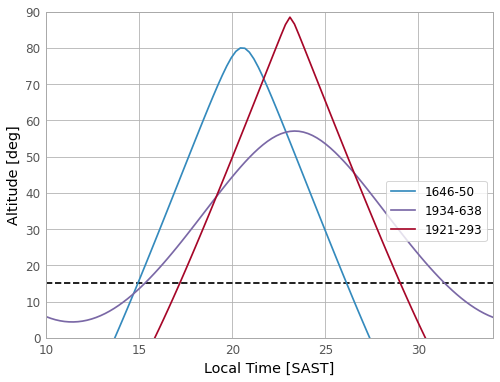

In [53]:
fig_rs = plt.figure(1)
ax_rs = fig_rs.add_subplot(111)

#-- set up the 
ax_rs.set_xlabel('Local Time '+time_zone)
ax_rs.set_ylabel('Altitude [deg]')
ax_rs.hlines(y = 15.0, xmin = 10.0, xmax = 34.0, linestyle = '--', color = 'k')
ax_rs.set_xlim([10.0,34.0])
ax_rs.set_ylim([0.0,90.0])


ix = 0

for target in targets:
    """Convert target coords to Az_el (called AltAz in astropy)"""
    target_azel = target.transform_to(AltAz(obstime = obs_period_start_local+obs_period_delta_local,
                                             location = geographic_location))
    ax_rs.plot(obs_period_delta_local+(float(obs_period_start_local.datetime.strftime("%H"))*u.hour),
               target_azel.alt,label=target_names[ix])
    ix += 1

ax_rs.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()